In [1]:
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import time
import copy
import os
import cv2
import glob
import random
from PIL import Image
from torch.autograd import Variable
import sklearn
import torch
print(torch.__version__)

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms


from torchinfo import summary



1.10.1+cu111


In [2]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### <学習モデル作成>

In [5]:
eff = models.efficientnet_b0(pretrained=True)

num_ftrs = eff.classifier[1].in_features

eff.classifier[1] = nn.Linear(num_ftrs, 2)

mnasnet = eff.to(device)
#mnasnet = copy.deepcopy(mnasnet).half()

In [6]:
summary(mnasnet)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─ConvNormActivation: 2-1                          --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

### <不均衡データに対する損失関数のウェイト計算>

In [7]:
def cla_list(DIR,a):
    
    return [a]*sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR))
    
class_list = []

class_list.extend(cla_list("train_data/other",0))
class_list.extend(cla_list("train_data/siren",1))


In [8]:
print("other",class_list.count(0))
print("siren",class_list.count(1))


other 1726
siren 6574


In [9]:
#https://androidkt.com/how-to-use-class-weight-in-crossentropyloss-for-an-imbalanced-dataset/

class_weights=sklearn.utils.class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(class_list), y = np.array(class_list))
class_weights=torch.tensor(class_weights,dtype=torch.float)

print(class_weights)

tensor([2.4044, 0.6313])


In [10]:
criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to(device)
optimizer = torch.optim.Adam(mnasnet.parameters(), lr=1e-4)

### <学習データ作成>

In [15]:
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor() # PyTorchで利用するTensorの形式にデータを変換
            ] )

data = torchvision.datasets.ImageFolder(root='train_data/', transform=transform)
cate = data.class_to_idx
print("カテゴリ名{}".format(data.class_to_idx))

カテゴリ名{'other': 0, 'siren': 1}


In [12]:
train_size = int(0.7 * len(data))
validation_size  = len(data) - train_size
data_size  = {"train":train_size, "validation":validation_size}

data_train, data_validation = torch.utils.data.random_split(data, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(data_validation, batch_size=32, shuffle=False)

dataloaders  = {"train":train_loader, "valid":validation_loader}

### <学習>

In [12]:
len(train_loader)

499

In [13]:
# エポック数
num_epochs = 30

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-------------')
    
    for phase in ['train', 'valid']:
        if phase == 'train':
            # 学習モードに設定
            mnasnet.train()
        else:
            # 訓練モードに設定
            mnasnet.eval()
            
        # epochの損失和
        epoch_loss = 0.0
        # epochの正解数
        epoch_corrects = 0
        count = 0

        for inputs, labels in dataloaders[phase]:

            # optimizerを初期化
            optimizer.zero_grad()

            print("\r\033{}/{}".format(count,len(dataloaders[phase])), end="")
            count += 1
            # 学習時のみ勾配を計算させる設定にする
            with torch.set_grad_enabled(phase == 'train'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print("pred_start")
                #start = time.time()
                outputs = mnasnet(inputs)
                #print(time.time()-start)
                
                
                # 損失を計算
                loss = criterion(outputs, labels)
                
                # ラベルを予測
                _, preds = torch.max(outputs, 1)
                
                # 訓練時は逆伝搬の計算
                if phase == 'train':
                    # 逆伝搬の計算
                    loss.backward()
                    
                    # パラメータ更新
                    optimizer.step()
                    
                # イテレーション結果の計算
                # lossの合計を更新
                # PyTorchの仕様上各バッチ内での平均のlossが計算される。
                # データ数を掛けることで平均から合計に変換をしている。
                # 損失和は「全データの損失/データ数」で計算されるため、
                # 平均のままだと損失和を求めることができないため。
                epoch_loss += loss.item() * inputs.size(0)
                
                # 正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)

        # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/30
-------------
498/499train Loss: 0.3634 Acc: 0.8863
213/214valid Loss: 0.5989 Acc: 0.8307
Epoch 2/30
-------------
498/499train Loss: 0.0517 Acc: 0.9841
213/214valid Loss: 0.3965 Acc: 0.8916
Epoch 3/30
-------------
498/499train Loss: 0.0224 Acc: 0.9940
213/214valid Loss: 0.2496 Acc: 0.9366
Epoch 4/30
-------------
498/499train Loss: 0.0162 Acc: 0.9954
213/214valid Loss: 0.2271 Acc: 0.9186
Epoch 5/30
-------------
498/499train Loss: 0.0085 Acc: 0.9981
213/214valid Loss: 0.1415 Acc: 0.9568
Epoch 6/30
-------------
498/499train Loss: 0.0072 Acc: 0.9977
213/214valid Loss: 0.2222 Acc: 0.9126
Epoch 7/30
-------------
498/499train Loss: 0.0088 Acc: 0.9981
213/214valid Loss: 0.0756 Acc: 0.9776
Epoch 8/30
-------------
498/499train Loss: 0.0041 Acc: 0.9984
213/214valid Loss: 0.0591 Acc: 0.9826
Epoch 9/30
-------------
498/499train Loss: 0.0045 Acc: 0.9984
213/214valid Loss: 0.0526 Acc: 0.9830
Epoch 10/30
-------------
498/499train Loss: 0.0035 Acc: 0.9990
213/214

In [13]:
import datetime

datetimeNow = datetime.datetime.now()   
dt = datetimeNowStr = datetimeNow.strftime("%Y%m%d%H%M%S%d")

torch.save(mnasnet.state_dict(), './model/{}_siren_2class.pth'.format(dt))

In [14]:
imsize = 224
loader = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name).convert("RGB")
    image = loader(image)
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    # CPU環境の場合は cuda() は不要
    return image.cuda()

m = nn.Softmax(dim=1)


In [17]:
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load("model/2023021015442110_siren_2class.pth"))
model.eval()
model.cuda()

print("model_load_sucsses")

model_load_sucsses


In [18]:
path = glob.glob("test_data/*/*jpg")
random.shuffle(path)

transform = transforms.Compose([
            transforms.Resize((244,224)),
            transforms.ToTensor()
            ] )

In [19]:
cate

{'other': 0, 'siren': 1}

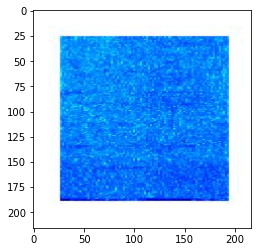

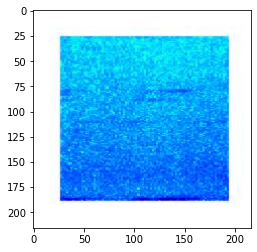

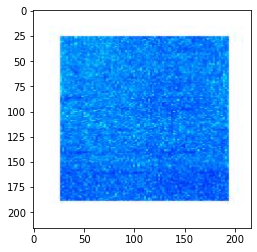

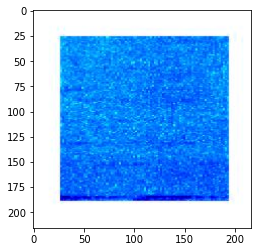

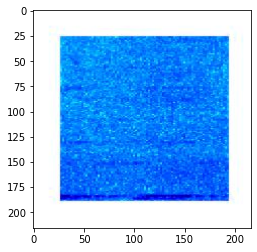

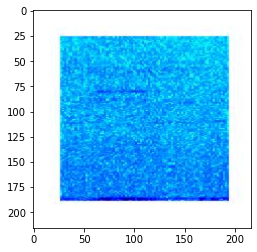

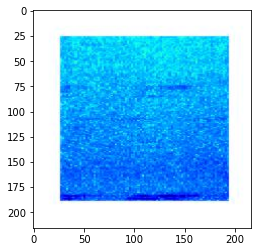

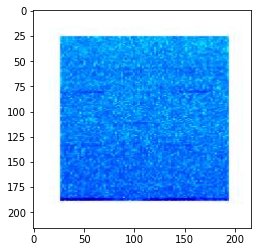

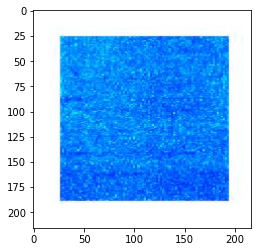

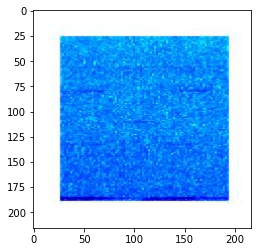

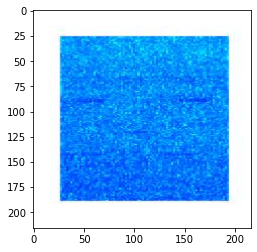

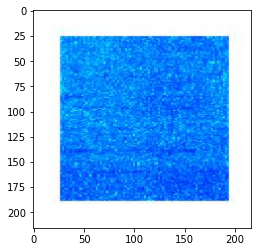

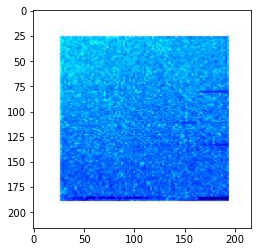

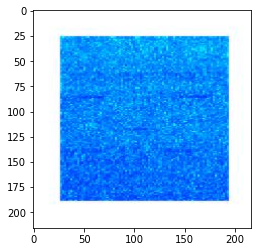

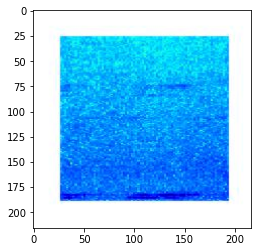

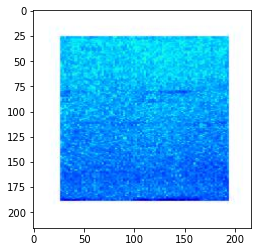

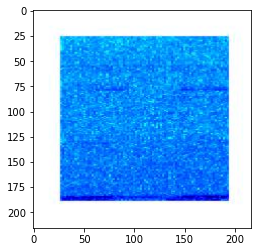

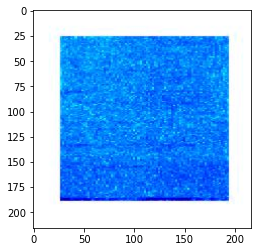

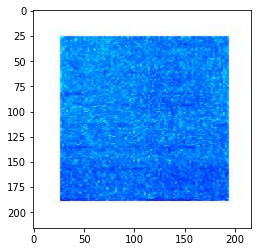

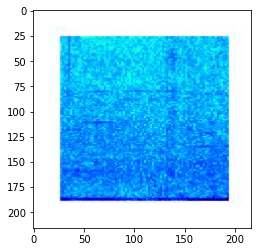

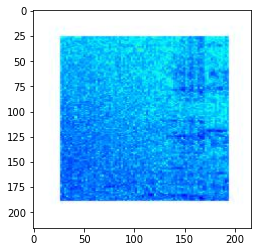

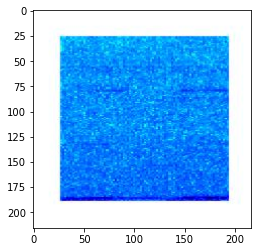

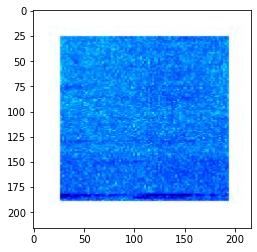

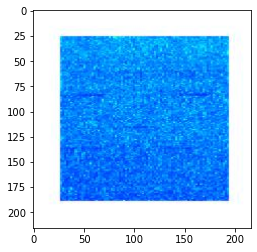

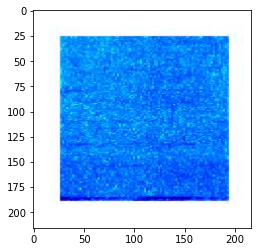

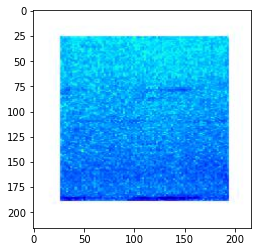

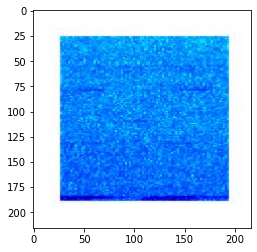

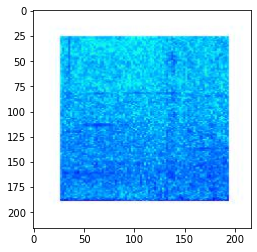

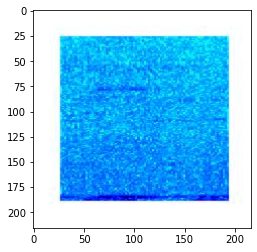

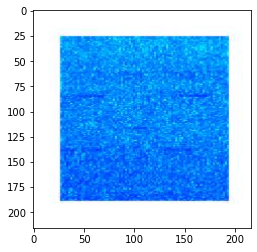

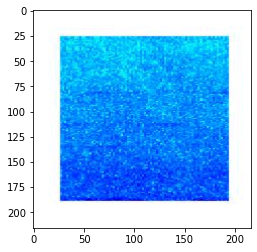

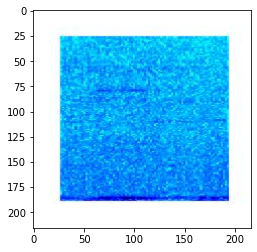

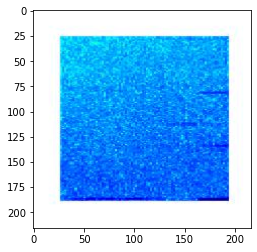

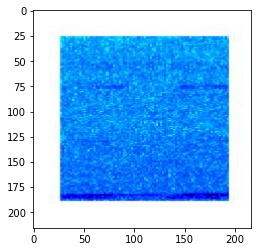

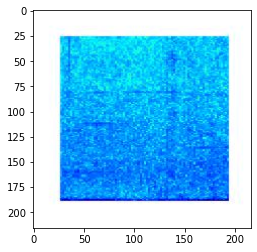

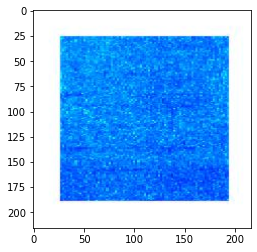

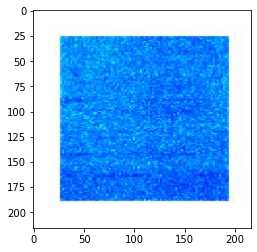

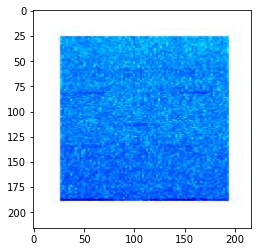

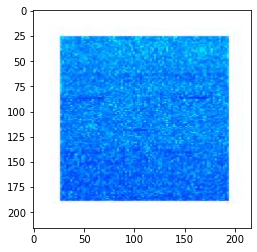

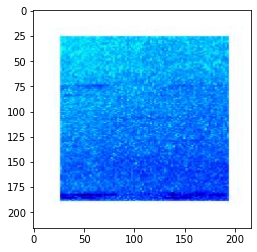

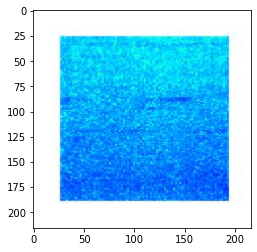

In [21]:
for i in path:
    
    img = image_loader(i)
    pred = torch.max(m(model(img)), 1)[1].to('cpu').detach().numpy().copy()

    if pred == 0:
        plt.imshow(cv2.imread(i))
        plt.show()
    
    